In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.contingency_tables import StratifiedTable
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';')

In [3]:
# Создаем функцию
def aa_test(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    n = 100000,
    simulations = 1000,
    n_s = 1000
):
    res = []

    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = data_column_1.sample(n_s, replace = False).values
        s2 = data_column_2.sample(n_s, replace = False).values
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()

    # Проверяем, что количество ложноположительных случаев не превышает альфа 
    print('FPR '+str(sum(np.array(res) <0.05) / simulations))

In [4]:
# Просматриваем данные
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


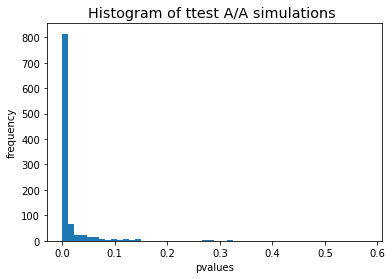

FPR 0.928


In [5]:
# Запускаем АА-тест по всем данным в разрезе experimentVariant
aa_test(df[(df.experimentVariant == 0)].purchase, df[(df.experimentVariant == 1)].purchase)
# И видим, что FPR > альфа. Значит сплит-система сломана.

In [6]:
# Считаем количество покупок в зависимости от версии МП
df.groupby(['experimentVariant','version'],as_index=False).agg(purchase_cnt=('purchase', 'sum'))

,experimentVariant,version,purchase_cnt
0,0,v2.8.0,41
1,0,v2.9.0,890
2,0,v3.7.4.0,252
3,0,v3.8.0.0,328
4,1,v2.8.0,1895
5,1,v2.9.0,858
6,1,v3.7.4.0,266
7,1,v3.8.0.0,384


In [7]:
# Посчитаем pvalue для каждой версии МП
# в этой версии pvalue < 0.05
stats.ttest_ind(
    df[(df.experimentVariant == 0) & (df.version == 'v2.8.0')].purchase, 
    df[(df.experimentVariant == 1) & (df.version == 'v2.8.0')].purchase)

Ttest_indResult(statistic=-42.963540840360324, pvalue=0.0)

In [8]:
# В этой и последующей больше pvalue > 0.05, значит выборки статистически незначимые
stats.ttest_ind(
    df[(df.experimentVariant == 0) & (df.version == 'v2.9.0')].purchase, 
    df[(df.experimentVariant == 1) & (df.version == 'v2.9.0')].purchase)

Ttest_indResult(statistic=0.9979597634962479, pvalue=0.31830895167207446)

In [9]:
stats.ttest_ind(
    df[(df.experimentVariant == 0) & (df.version == 'v3.7.4.0')].purchase, 
    df[(df.experimentVariant == 1) & (df.version == 'v3.7.4.0')].purchase)

Ttest_indResult(statistic=-0.5874925850487471, pvalue=0.5568886771079735)

In [10]:
stats.ttest_ind(
    df[(df.experimentVariant == 0) & (df.version == 'v3.8.0.0')].purchase, 
    df[(df.experimentVariant == 1) & (df.version == 'v3.8.0.0')].purchase)

Ttest_indResult(statistic=-1.1956188950206779, pvalue=0.23186933664059722)

In [11]:
# Исключаем версию с pvalue < 0.05 из основного датафрейма
df1 = df.query("version != 'v2.8.0'")

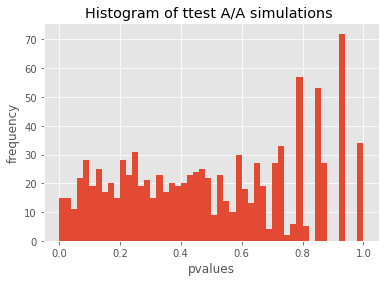

FPR 0.031


In [12]:
# Повторно запускаем расчет FPR через A/A. Теперь FPR < альфа
# Мы нашли поломку
aa_test(df1[(df1.experimentVariant == 0)].purchase, df1[(df1.experimentVariant == 1)].purchase)

In [14]:
# Воспользуемся альтернативным расчетом
# начальная таблица
StratifiedTable.from_data('experimentVariant', 'purchase', 'version', df).summary()

,Estimate,LCB,UCB
Pooled odds,2.300,2.161,2.447
Pooled log odds,0.833,0.771,0.895
Pooled risk ratio,1.031,,
,,,
,Statistic,P-value,
Test of OR=1,734.655,0.000,
Test constant OR,1256.880,0.000,
,,,
Number of tables,4,,
Min n,8425,,


In [15]:
# после удаления ошибки
StratifiedTable.from_data('experimentVariant', 'purchase', 'version', df1).summary()

,Estimate,LCB,UCB
Pooled odds,1.003,0.931,1.080
Pooled log odds,0.003,-0.072,0.077
Pooled risk ratio,1.000,,
,,,
,Statistic,P-value,
Test of OR=1,0.005,0.944,
Test constant OR,2.766,0.251,
,,,
Number of tables,3,,
Min n,8425,,


In [16]:
# Первая строчка (где Test of OR = 1) — это проверка гипотезы о независимости переменных, 
# вторая строчка (где Test constant OR) — проверка гипотезы об одинаковости связи по всем уровням стратифицирующей переменной.
# До удаления - разные связи по уровню стратифицирующей переменной и связь одинакова во всех стратах.
# после удаления видно, что между переменными есть одинаковая связь, и эта связь теперь стала независимой.